## Ejercicio de predicción #0805

### 1. Series de tiempo y predicción:

In [1]:
import numpy as np
import pandas as pd
import os
import warnings 
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, TimeDistributed
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
warnings.filterwarnings('ignore')                  # Desactivar las advertencias.
%matplotlib inline

Using TensorFlow backend.


#### 1.1. Leer los datos y explorar: 

In [2]:
# Ir al directorio que contiene el archivo. 
# os.chdir(r'~~')                # Reemplazar por la ruta adecuada   

In [3]:
df = pd.read_csv('data_time_series.csv', header='infer',encoding = 'latin1')
n_time_steps = df.shape[0]
print(df.shape)

(41, 1)


In [4]:
# Mostrar el DataFrame.
df.head()

,Value
0,2.26483
1,3.80588
2,4.21088
3,3.48790
4,4.86365


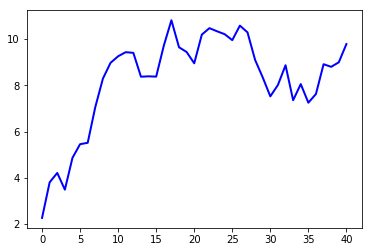

In [5]:
# Visualizar las series de tiempo.
plt.plot(df.Value, c="b", linewidth=2, linestyle="-")
plt.show()

#### 1.2. Aplicar el método de suavizado exponencial y predecir:

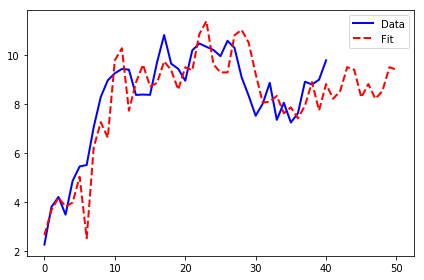

In [6]:
model = ExponentialSmoothing(df['Value'][0:40], seasonal='mul',seasonal_periods=6).fit()    # Multiplicative exponential smoothing model.
pred = model.predict(start= 0, end=50)                                                        
plt.plot(df,c='b',linewidth=2, linestyle="-", label="Data")
plt.plot(pred,c='r',linewidth=2, linestyle="--", label="Fit")
plt.legend()
plt.tight_layout()
plt.show()

### 2. Red Neuronal Recurrente (RNN):

#### 2.1. Preprocesado:

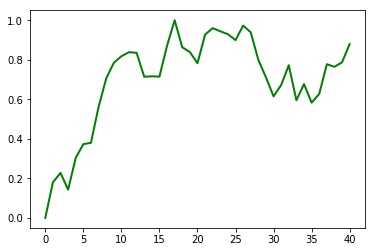

In [7]:
# Escalado.
# Por favor, prestar atención a la escala vertical del gráfico.
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(df)
plt.plot(ts_scaled,c = "g", linewidth=2, linestyle="-")
plt.show()

In [8]:
# Reorganización.
ts_scaled_2 = ts_scaled.reshape(1,-1,1)             # (batch_size, longitud de la serie temporal, n_input)

#### 2.2. Hacer las definiciones necesarias:

Hiperparámetros.

In [9]:
n_epochs = 1001                   
batch_size = 1                    # Solo hay 1 serie de datos de tiempo. No hay otra opción que 1.
learn_rate = 0.0002       

In [10]:
n_input = 1                       # Entrada escalar.
n_neurons = 100                   # N# de neuronas por capa
n_output = 1                      # Salida escalar.

Modelo.

In [11]:
# Red RNN o LSTM.
# return_sequnces = True: significa "secuencia a secuencia".
# input_shape = (None, n_inputs) : longitud variable de la serie temporal.
my_model = Sequential()
my_model.add(SimpleRNN(units=n_neurons,return_sequences=True, input_shape=(None, n_input)))     # RNN.
# my_model.add(LSTM(units=n_neurons,return_sequences=True, input_shape=(None, n_input)))         # LSTM.
my_model.add(TimeDistributed(Dense(units=n_output, activation="linear")))    # Envoltura.

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
# Resumen
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 100)         10200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1)           101       
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Definir el optimizador y complilar.
my_optimizer=Adam(lr=learn_rate)
my_model.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

#### 2.3. Entrenar el modelo:

In [14]:
# Sin validación.
# PRECAUCIÓN: y es X desplazada en +1.
my_summary = my_model.fit(ts_scaled_2[:,:-1,:], ts_scaled_2[:,1:,:], epochs=n_epochs, batch_size = batch_size, verbose = 0)

Instructions for updating:
Use tf.cast instead.


In [15]:
my_summary.history.keys()

dict_keys(['loss', 'mean_squared_error'])

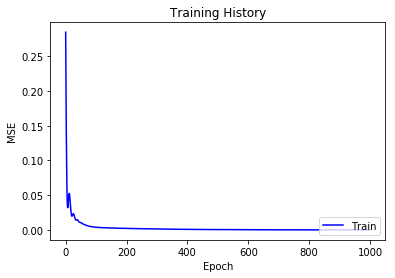

In [17]:
plt.plot(my_summary.history['mean_squared_error'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

#### 2.4. Predecir el futuro:

In [18]:
n_ts_seed = 5                                 # Longitud de la semilla.
n_predict_time_steps = 55                     # longitud de predicción.

In [19]:
# Bucle de predicción.
ts_seed = ts_scaled[0:n_ts_seed]
for i in range(n_predict_time_steps):
    X = ts_seed.reshape(1,-1,1)        # Reorganizar.     
    y_pred = my_model.predict(X)
    y_last= y_pred[0,-1,0]             # La última salida es la y predicha.
    ts_seed = np.concatenate((ts_seed, np.array([y_last]).reshape(1,1)), axis=0)

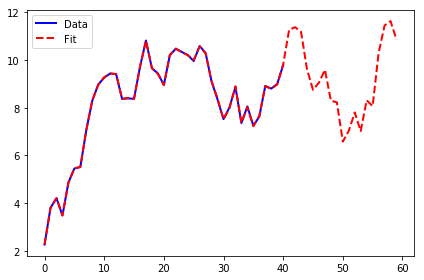

In [20]:
# Hacer la transformación inversa y mostrar la serie temporal.
ts = scaler.inverse_transform(ts_seed)
plt.plot(df.Value,c='b',linewidth=2, linestyle="-",label="Data")
plt.plot(ts,c='r',linewidth=2, linestyle="--",label="Fit")
plt.legend()
plt.tight_layout()
plt.savefig("out.png")
plt.show()